# Выпускная квалификационная работа.
**Тема:** *«Применение методов машинного обучения к задаче классификации сетевых атак»*
**Выполнил:** *Моисейко Николай Николаевич*

### 2022г

In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder
from sklearn import metrics
import warnings
import pickle

In [22]:
#блок надстроек
pd.set_option('display.max_columns', None)
sns.set_style('darkgrid')
warnings.filterwarnings("ignore")

In [23]:
#The full NSL-KDD test set including attack-type labels and difficulty level in CSV format. Exclude Nan data.
#Датасет в котором аномальный трафик разбит на лэйблы, те в netbios_ssn содержатся уже рельные лэйблы аномального трафика
#x0 - x41 – информационные признаки, x42 – метка класса атаки (как написано в документации)
dataset = pd.read_csv('../OTUS-MLPRO-FinalQualifyingWork/KDDTrain+-labels.csv', sep=',', header=None)
dataset.head(5)

0    1         2   3    4     5   6   7   8   9   10  11  12  13  14  15  \
0   0  tcp  ftp_data  SF  491     0   0   0   0   0   0   0   0   0   0   0   
1   0  udp     other  SF  146     0   0   0   0   0   0   0   0   0   0   0   
2   0  tcp   private  S0    0     0   0   0   0   0   0   0   0   0   0   0   
3   0  tcp      http  SF  232  8153   0   0   0   0   0   1   0   0   0   0   
4   0  tcp      http  SF  199   420   0   0   0   0   0   1   0   0   0   0   

   16  17  18  19  20  21   22  23   24   25   26   27    28    29    30   31  \
0   0   0   0   0   0   0    2   2  0.0  0.0  0.0  0.0  1.00  0.00  0.00  150   
1   0   0   0   0   0   0   13   1  0.0  0.0  0.0  0.0  0.08  0.15  0.00  255   
2   0   0   0   0   0   0  123   6  1.0  1.0  0.0  0.0  0.05  0.07  0.00  255   
3   0   0   0   0   0   0    5   5  0.2  0.2  0.0  0.0  1.00  0.00  0.00   30   
4   0   0   0   0   0   0   30  32  0.0  0.0  0.0  0.0  1.00  0.00  0.09  255   

    32    33    34    35    36    37    38    39    40       41  42  
0   25  0.17  0.03  0.17  0.00  0.00  0.00  0.05  0.00   normal  20  
1    1  0.00  0.60  0.88  0.00  0.00  0.00  0.00  0.00   normal  15  
2   26  0.10  0.05  0.00  0.00  1.00  1.00  0.00  0.00  neptune  19  
3  255  1.00  0.00  0.03  0.04  0.03  0.01  0.00  0.01   normal  21  
4  255  1.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00   normal  21

In [24]:
dataset.shape

(125973, 43)

In [25]:
#Функция предобработки дататсета
def preproc(dataset):
    enc = OrdinalEncoder()
    
    dataset.columns=['duration','tcp','udp','icmp','aol','auth','bgp','courier','csnet_ns','ctf','daytime','discard','domain','domain_u','echo','eco_i','ecr_i','efs','exec','finger','ftp','ftp_data','gopher','harvest','hostnames','http','http_2784','http_443','http_8001','imap4','IRC','iso_tsap','klogin','kshell','ldap','link','login','mtp','name','netbios_dgm','netbios_ns','netbios_ssn', 'class_attack']
    dataset['traf_descr_lbl']=dataset['netbios_ssn']
    dataset[['tcp', 'udp', 'icmp', 'traf_descr_lbl']]=enc.fit_transform(dataset[['tcp', 'udp', 'icmp', 'traf_descr_lbl']])
    
    return dataset

preproc(dataset)

#ф-я кодирования значений переменной traf_descr_lbl
def ohencoder(dataset) -> list:
    
    ohe = OneHotEncoder(sparse=False, handle_unknown='ignore')
    dataset['traf']=pd.Series(['normal' if label == 'normal' else 'anomaly' for label in dataset['netbios_ssn']])
    dataset['traf']=ohe.fit_transform(dataset[['traf']])
    return dataset

ohencoder(dataset)

duration  tcp   udp  icmp   aol  auth  bgp  courier  csnet_ns  ctf  \
0              0  1.0  20.0   9.0   491     0    0        0         0    0   
1              0  2.0  44.0   9.0   146     0    0        0         0    0   
2              0  1.0  49.0   5.0     0     0    0        0         0    0   
3              0  1.0  24.0   9.0   232  8153    0        0         0    0   
4              0  1.0  24.0   9.0   199   420    0        0         0    0   
...          ...  ...   ...   ...   ...   ...  ...      ...       ...  ...   
125968         0  1.0  49.0   5.0     0     0    0        0         0    0   
125969         8  2.0  49.0   9.0   105   145    0        0         0    0   
125970         0  1.0  54.0   9.0  2231   384    0        0         0    0   
125971         0  1.0  30.0   5.0     0     0    0        0         0    0   
125972         0  1.0  20.0   9.0   151     0    0        0         0    0   

        daytime  discard  domain  domain_u  echo  eco_i  ecr_i  efs  exec  \
0             0        0       0         0     0      0      0    0     0   
1             0        0       0         0     0      0      0    0     0   
2             0        0       0         0     0      0      0    0     0   
3             0        1       0         0     0      0      0    0     0   
4             0        1       0         0     0      0      0    0     0   
...         ...      ...     ...       ...   ...    ...    ...  ...   ...   
125968        0        0       0         0     0      0      0    0     0   
125969        0        0       0         0     0      0      0    0     0   
125970        0        1       0         0     0      0      0    0     0   
125971        0        0       0         0     0      0      0    0     0   
125972        0        1       0         0     0      0      0    0     0   

        finger  ftp  ftp_data  gopher  harvest  hostnames  http  http_2784  \
0            0    0         0       2        2        0.0   0.0        0.0   
1            0    0         0      13        1        0.0   0.0        0.0   
2            0    0         0     123        6        1.0   1.0        0.0   
3            0    0         0       5        5        0.2   0.2        0.0   
4            0    0         0      30       32        0.0   0.0        0.0   
...        ...  ...       ...     ...      ...        ...   ...        ...   
125968       0    0         0     184       25        1.0   1.0        0.0   
125969       0    0         0       2        2        0.0   0.0        0.0   
125970       0    0         0       1        1        0.0   0.0        0.0   
125971       0    0         0     144        8        1.0   1.0        0.0   
125972       0    0         0       1        1        0.0   0.0        0.0   

        http_443  http_8001  imap4   IRC  iso_tsap  klogin  kshell  ldap  \
0            0.0       1.00   0.00  0.00       150      25    0.17  0.03   
1            0.0       0.08   0.15  0.00       255       1    0.00  0.60   
2            0.0       0.05   0.07  0.00       255      26    0.10  0.05   
3            0.0       1.00   0.00  0.00        30     255    1.00  0.00   
4            0.0       1.00   0.00  0.09       255     255    1.00  0.00   
...          ...        ...    ...   ...       ...     ...     ...   ...   
125968       0.0       0.14   0.06  0.00       255      25    0.10  0.06   
125969       0.0       1.00   0.00  0.00       255     244    0.96  0.01   
125970       0.0       1.00   0.00  0.00       255      30    0.12  0.06   
125971       0.0       0.06   0.05  0.00       255       8    0.03  0.05   
125972       0.0       1.00   0.00  0.00       255      77    0.30  0.03   

        link  login   mtp  name  netbios_dgm  netbios_ns netbios_ssn  \
0       0.17   0.00  0.00  0.00         0.05        0.00      normal   
1       0.88   0.00  0.00  0.00         0.00        0.00      normal   
2       0.00   0.00  1.00  1.00         0.00        0.00     neptune   
3       

In [26]:
dataset.shape

(125973, 45)

# EDA

In [27]:
#смотрим тип данных и пропуски в них
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 125973 entries, 0 to 125972
Data columns (total 45 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   duration        125973 non-null  int64  
 1   tcp             125973 non-null  float64
 2   udp             125973 non-null  float64
 3   icmp            125973 non-null  float64
 4   aol             125973 non-null  int64  
 5   auth            125973 non-null  int64  
 6   bgp             125973 non-null  int64  
 7   courier         125973 non-null  int64  
 8   csnet_ns        125973 non-null  int64  
 9   ctf             125973 non-null  int64  
 10  daytime         125973 non-null  int64  
 11  discard         125973 non-null  int64  
 12  domain          125973 non-null  int64  
 13  domain_u        125973 non-null  int64  
 14  echo            125973 non-null  int64  
 15  eco_i           125973 non-null  int64  
 16  ecr_i           125973 non-null  int64  
 17  efs       

In [28]:
#пропусков нет. убедимся в этом
np.round(dataset.isna().sum()[dataset.isna().sum()>0] / dataset.shape[0], 2)

Series([], dtype: float64)

In [29]:
#статистика по данным
dataset.describe()

duration            tcp            udp           icmp  \
count  125973.00000  125973.000000  125973.000000  125973.000000   
mean      287.14465       1.053202      31.226469       6.979996   
std      2604.51531       0.426620      16.346470       2.689365   
min         0.00000       0.000000       0.000000       0.000000   
25%         0.00000       1.000000      20.000000       5.000000   
50%         0.00000       1.000000      24.000000       9.000000   
75%         0.00000       1.000000      49.000000       9.000000   
max     42908.00000       2.000000      69.000000      10.000000   

                aol          auth            bgp        courier  \
count  1.259730e+05  1.259730e+05  125973.000000  125973.000000   
mean   4.556674e+04  1.977911e+04       0.000198       0.022687   
std    5.870331e+06  4.021269e+06       0.014086       0.253530   
min    0.000000e+00  0.000000e+00       0.000000       0.000000   
25%    0.000000e+00  0.000000e+00       0.000000       0.000000   
50%    4.400000e+01  0.000000e+00       0.000000       0.000000   
75%    2.760000e+02  5.160000e+02       0.000000       0.000000   
max    1.379964e+09  1.309937e+09       1.000000       3.000000   

            csnet_ns            ctf        daytime        discard  \
count  125973.000000  125973.000000  125973.000000  125973.000000   
mean        0.000111       0.204409       0.001222       0.395736   
std         0.014366       2.149968       0.045239       0.489010   
min         0.000000       0.000000       0.000000       0.000000   
25%         0.000000       0.000000       0.000000       0.000000   
50%         0.000000       0.000000       0.000000       0.000000   
75%         0.000000       0.000000       0.000000       1.000000   
max         3.000000      77.000000       5.000000       1.000000   

              domain       domain_u           echo          eco_i  \
count  125973.000000  125973.000000  125973.000000  125973.000000   
mean        0.279250       0.001342       0.001103       0.302192   
std        23.942042       0.036603       0.045154      24.399618   
min         0.000000       0.000000       0.000000       0.000000   
25%         0.000000       0.000000       0.000000       0.000000   
50%         0.000000       0.000000       0.000000       0.000000   
75%         0.000000       0.000000       0.000000       0.000000   
max      7479.000000       1.000000       2.000000    7468.000000   

               ecr_i            efs           exec    finger            ftp  \
count  125973.000000  125973.000000  125973.000000  125973.0  125973.000000   
mean        0.012669       0.000413       0.004096       0.0       0.000008   
std         0.483935       0.022181       0.099370       0.0       0.002817   
min         0.000000       0.000000       0.000000       0.0       0.000000   
25%         0.000000       0.000000       0.000000       0.0       0.000000   
50%         0.000000       0.000000       0.000000       0.0       0.000000   
75%         0.000000       0.000000       0.000000       0.0       0.000000   
max        43.000000       2.000000       9.000000       0.0       1.000000   

            ftp_data         gopher        harvest      hostnames  \
count  125973.000000  125973.000000  125973.000000  125973.000000   
mean        0.009423      84.107555      27.737888       0.284485   
std         0.096612     114.508607      72.635840       0.446456   
min         0.000000       0.000000       0.000000       0.000000   
25%         0.000000       2.000000       2.000000       0.000000   
50%         0.000000      14.000000       8.000000       0.000000   
75%         0.000000     143.000000      18.000000       1.000000   
max         1.000000     511.000000     511.000000       1.000000   

                http      http_2784       http_443      http_8001  \
count  125973.000000  125973.000000  125973.000000  125973.000000   
mean        0.282485       0.119958       0.121183       0.660928   
std      

In [30]:
#уникальные значения по лэйблам атак
netbios_ssn = pd.unique(dataset['netbios_ssn'])
netbios_ssn

array(['normal', 'neptune', 'warezclient', 'ipsweep', 'portsweep',
       'teardrop', 'nmap', 'satan', 'smurf', 'pod', 'back',
       'guess_passwd', 'ftp_write', 'multihop', 'rootkit',
       'buffer_overflow', 'imap', 'warezmaster', 'phf', 'land',
       'loadmodule', 'spy', 'perl'], dtype=object)

In [31]:
#уникальные значения по закодированым лэйблам атак
traf_descr_lbl = pd.unique(dataset['traf_descr_lbl'])
traf_descr_lbl

    #len=23

array([11.,  9., 21.,  5., 15., 20., 10., 17., 18., 14.,  0.,  3.,  2.,
        8., 16.,  1.,  4., 22., 13.,  6.,  7., 19., 12.])

In [32]:
#уникальные значения по протоколу tcp
tcp = pd.unique(dataset['tcp'])
tcp

    #'tcp', 'icmp', 'udp'
    #len=3

array([1., 2., 0.])

In [33]:
#уникальные значения по протоколу udp
udp = pd.unique(dataset['udp'])
udp

    #'private', 'ftp_data', 'eco_i', 'telnet', 'http', 'smtp', 'ftp', 
    #'ldap', 'pop_3', 'courier', 'discard', 'ecr_i', 'imap4',
    #'domain_u', 'mtp', 'systat', 'iso_tsap', 'other', 'csnet_ns',
    #'finger', 'uucp', 'whois', 'netbios_ns', 'link', 'Z39_50',
    #'sunrpc', 'auth', 'netbios_dgm', 'uucp_path', 'vmnet', 'domain',
    #'name', 'pop_2', 'http_443', 'urp_i', 'login', 'gopher', 'exec',
    #'time', 'remote_job', 'ssh', 'kshell', 'sql_net', 'shell',
    #'hostnames', 'echo', 'daytime', 'pm_dump', 'IRC', 'netstat', 'ctf',
    #'nntp', 'netbios_ssn', 'tim_i', 'supdup', 'bgp', 'nnsp', 'rje',
    #'printer', 'efs', 'X11', 'ntp_u', 'klogin', 'tftp_u'
    #len=70

array([20., 44., 49., 24., 51., 36., 38., 14., 35., 60., 18., 12., 58.,
       67.,  2., 54.,  7., 66., 37., 65.,  4., 11., 19.,  5., 32., 15.,
       21., 68., 59., 26., 16., 69., 28., 29., 13., 30., 33., 57., 34.,
       31., 55., 63., 23., 17., 43., 10., 42.,  6.,  8., 56.,  9., 53.,
       40., 47., 41.,  0., 46., 48., 62., 45., 50., 39., 52.,  1., 64.,
       27.,  3., 25., 61., 22.])

In [34]:
#уникальные значения по протоколу icmp
icmp = pd.unique(dataset['icmp'])
icmp

    #'REJ', 'SF', 'RSTO', 'S0', 'RSTR', 'SH', 'S3', 'S2', 'S1', 'RSTOS0', 'OTH'
    #len=11

array([ 9.,  5.,  1.,  4., 10.,  2.,  6.,  3.,  8.,  7.,  0.])

In [35]:
#уникальные значения по duration (продолжитеьность времени сетевой атаки)
duration = pd.unique(dataset['duration'])
duration

    #len=2981

array([    0,  5607,   507, ...,  5430, 11680,   679], dtype=int64)

In [36]:
#уникальные значения по duration (продолжитеьность времени сетевой атаки)
traf = pd.unique(dataset['traf'])
traf

    #len=2

array([0., 1.])

In [37]:
#метка класса атаки
class_attack = pd.unique(dataset['class_attack'])
class_attack

array([20, 15, 19, 21, 18, 17, 16, 12, 14, 11,  2, 13, 10,  9,  8,  7,  3,
        5,  1,  6,  0,  4], dtype=int64)

In [38]:
print('count "netbios_ssn" = ', len(netbios_ssn))
print('count "traf_descr_lbl" = ', len(traf_descr_lbl))
print('count "tcp" = ', len(tcp))
print('count "udp" = ', len(udp))
print('count "icmp" = ', len(icmp))
print('count "duration" = ', len(duration))
print('count "traf = ', len(traf))
print('count "class_attack = ', len(class_attack))

count "netbios_ssn" =  23
count "traf_descr_lbl" =  23
count "tcp" =  3
count "udp" =  70
count "icmp" =  11
count "duration" =  2981
count "traf =  2
count "class_attack =  22


In [39]:
#статистика по типам атак
count=dataset.groupby('netbios_ssn')['netbios_ssn'].count()
count
#val_count=dataset['netbios_ssn'].value_counts()
#val_count

netbios_ssn
back                 956
buffer_overflow       30
ftp_write              8
guess_passwd          53
imap                  11
ipsweep             3599
land                  18
loadmodule             9
multihop               7
neptune            41214
nmap                1493
normal             67343
perl                   3
phf                    4
pod                  201
portsweep           2931
rootkit               10
satan               3633
smurf               2646
spy                    2
teardrop             892
warezclient          890
warezmaster           20
Name: netbios_ssn, dtype: int64

In [40]:
#посмотрим на распределние атак по протоколу "tcp"
dataset.groupby(['tcp'])['netbios_ssn'].value_counts(normalize=True)

tcp  netbios_ssn    
0.0  ipsweep            0.375950
     smurf              0.319141
     normal             0.157882
     nmap               0.118321
     pod                0.024243
     satan              0.003860
     portsweep          0.000603
1.0  normal             0.521964
     neptune            0.401348
     portsweep          0.028494
     satan              0.021268
     back               0.009310
     warezclient        0.008667
     ipsweep            0.004694
     nmap               0.002581
     guess_passwd       0.000516
     buffer_overflow    0.000292
     warezmaster        0.000195
     land               0.000175
     imap               0.000107
     loadmodule         0.000088
     ftp_write          0.000078
     multihop           0.000068
     rootkit            0.000068
     phf                0.000039
     perl               0.000029
     spy                0.000019
2.0  normal             0.829320
     satan              0.094511
     teardrop         

In [41]:
#посмотрим на распределние атак по протоколу "udp"
dataset.groupby(['udp'])['netbios_ssn'].value_counts(normalize=True)

udp   netbios_ssn
0.0   normal         0.994652
      satan          0.005348
1.0   normal         0.917808
      satan          0.082192
2.0   neptune        0.987239
                       ...   
69.0  neptune        0.966811
      portsweep      0.020202
      ipsweep        0.007215
      satan          0.004329
      nmap           0.001443
Name: netbios_ssn, Length: 301, dtype: float64

In [42]:
#посмотрим на распределние атак по протоколу "icmp"
dataset.groupby(['icmp'])['netbios_ssn'].value_counts(normalize=True)

icmp  netbios_ssn
0.0   portsweep      0.760870
      normal         0.239130
1.0   neptune        0.504852
      normal         0.239740
      satan          0.174842
                       ...   
9.0   spy            0.000027
      neptune        0.000013
10.0  nmap           0.977860
      imap           0.014760
      normal         0.007380
Name: netbios_ssn, Length: 64, dtype: float64

In [43]:
dataset.groupby(['class_attack'])['netbios_ssn'].value_counts(normalize=True)

class_attack  netbios_ssn
0             warezclient    0.575758
              satan          0.363636
              ipsweep        0.015152
              loadmodule     0.015152
              perl           0.015152
                               ...   
21            neptune        0.212031
              satan          0.001327
              portsweep      0.000480
              smurf          0.000224
              nmap           0.000032
Name: netbios_ssn, Length: 247, dtype: float64

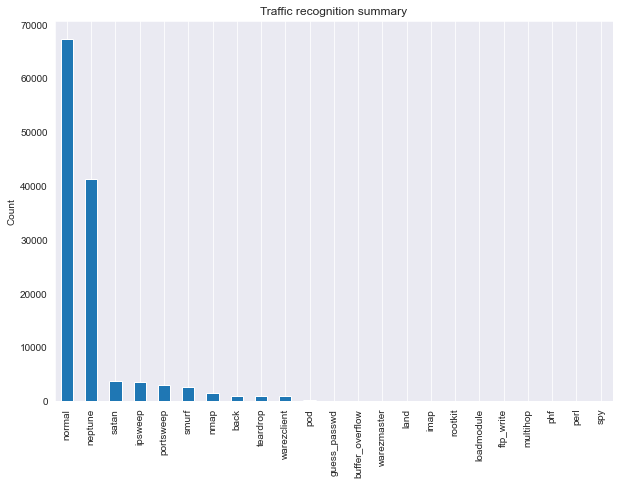

In [26]:
#граф распределения атак по количеству записей в датасете
dataset['netbios_ssn'].value_counts().plot.bar(figsize=(10,7), title='Traffic recognition summary').set_ylabel('Count');
plt.grid(axis='y')

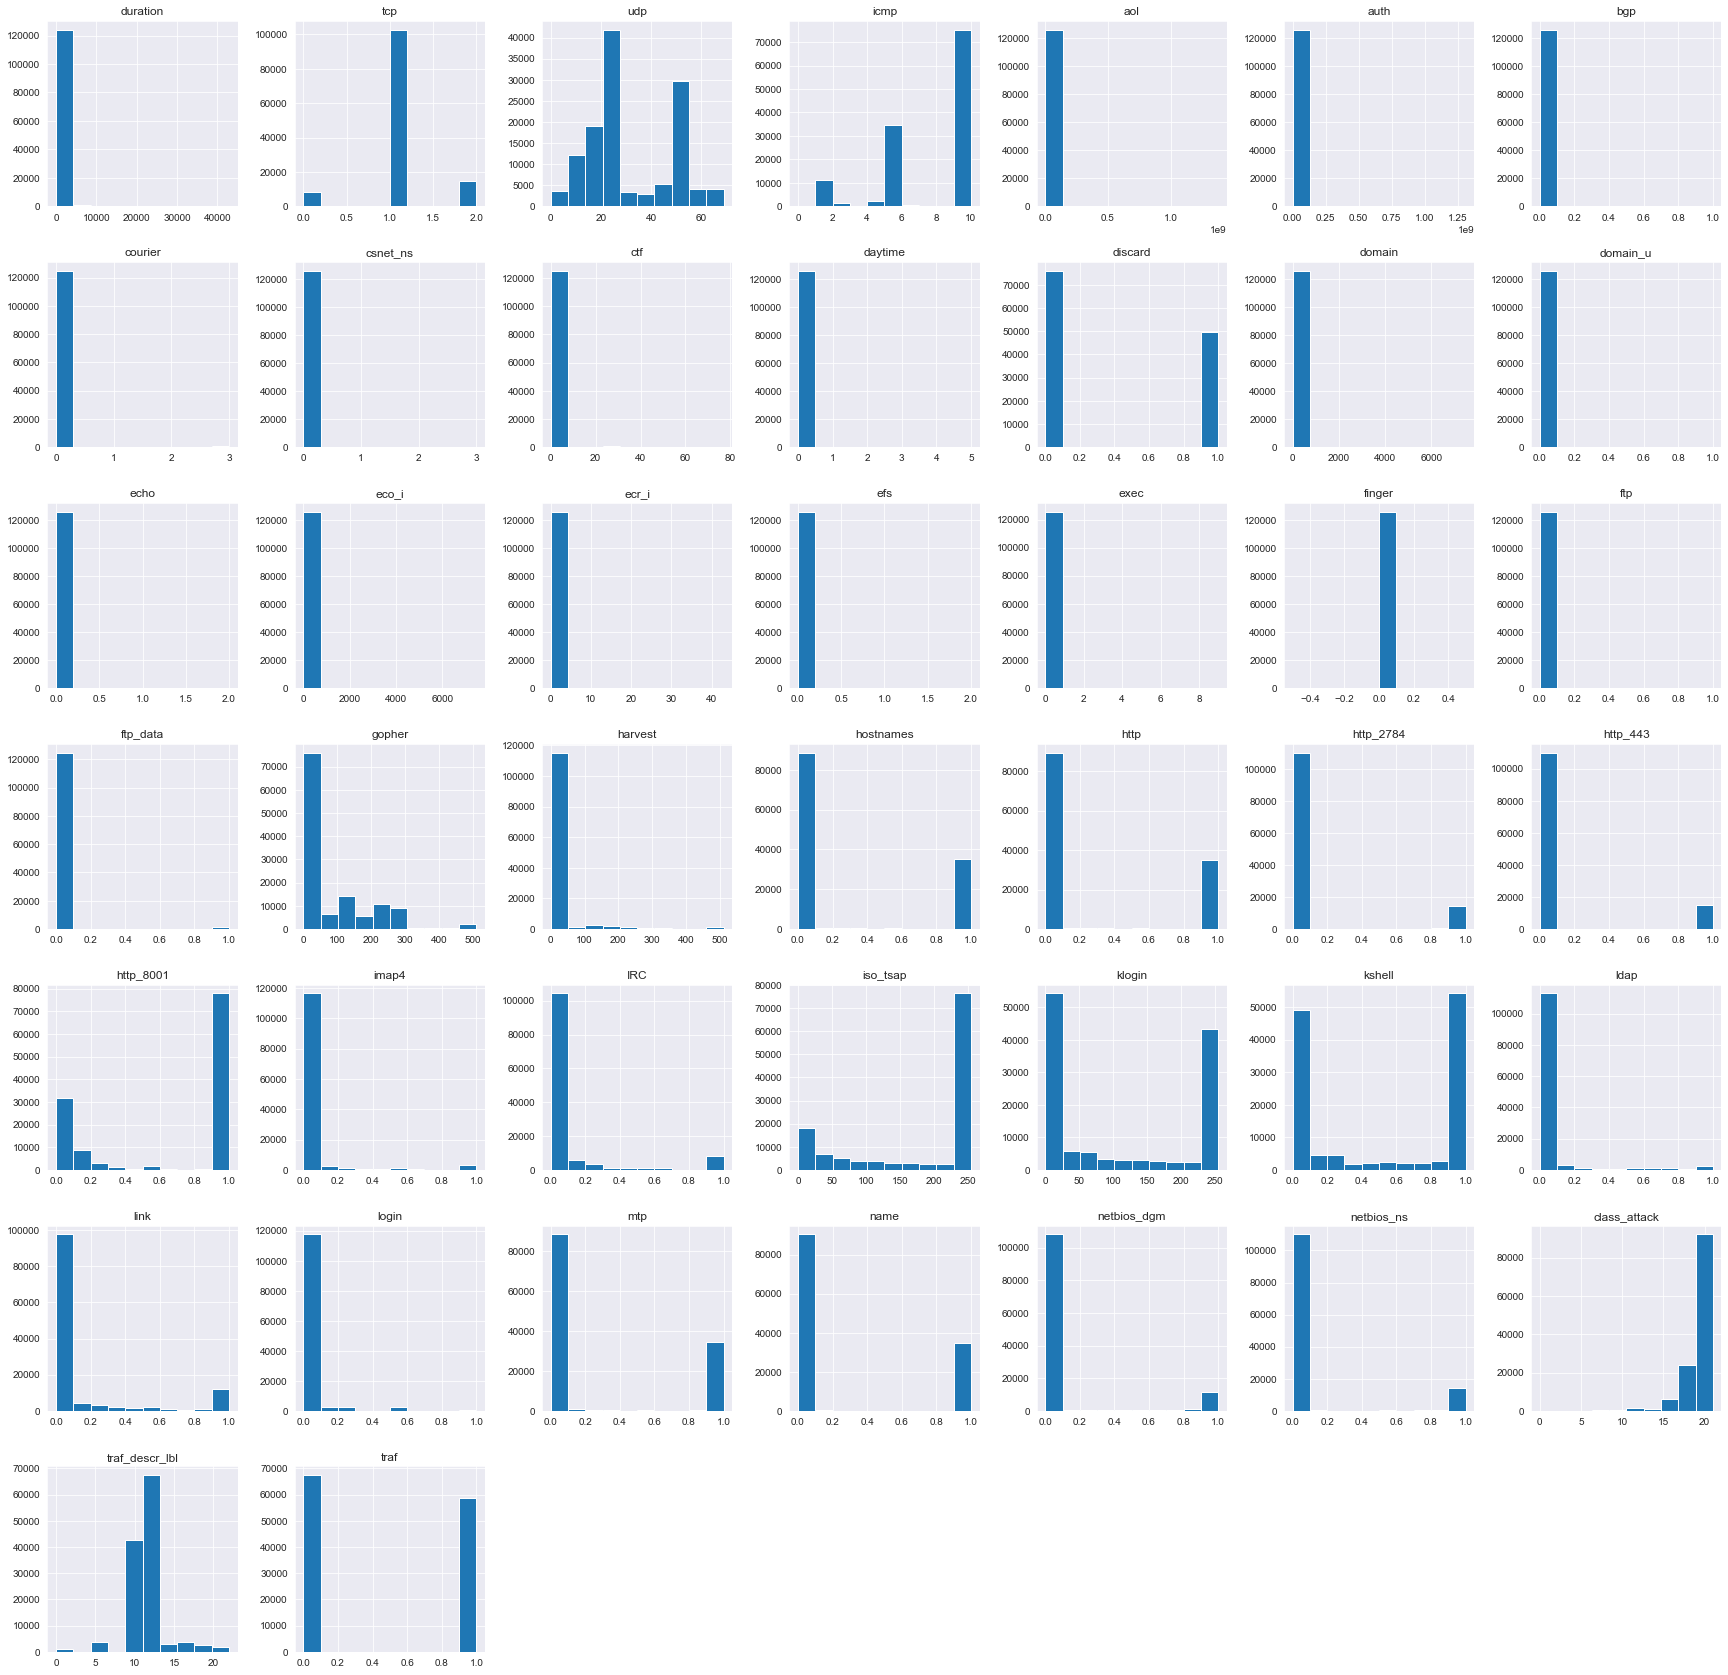

In [25]:
dataset.hist(figsize=(30,30));

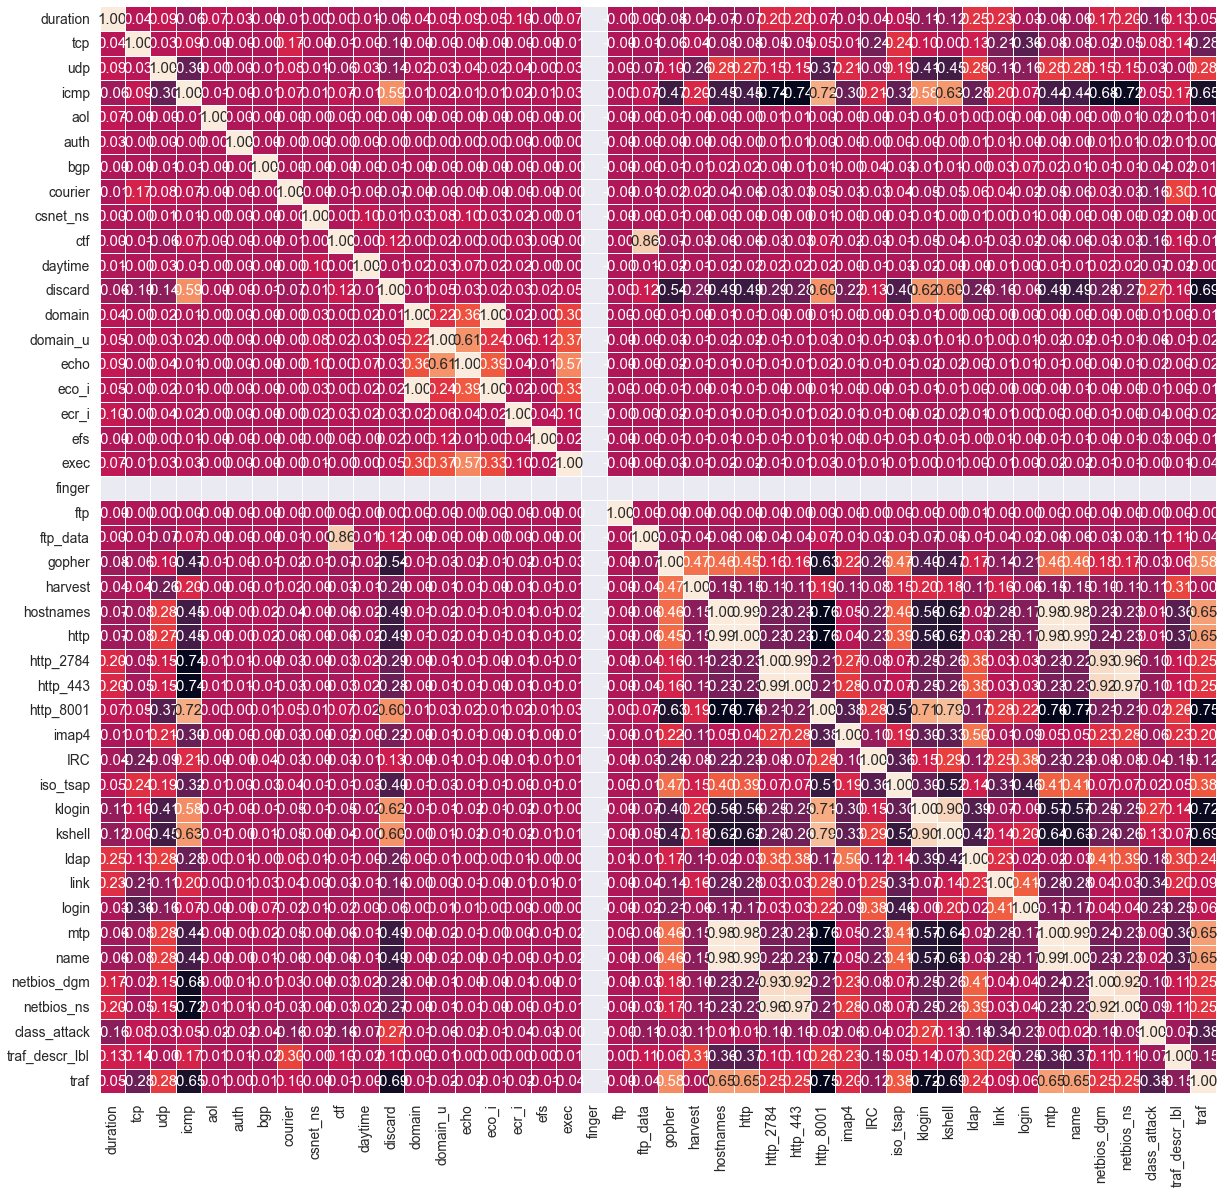

In [171]:
#матрица корреляции
plt.figure(figsize=(20,20))
sns.heatmap(dataset.corr(), annot=True, cbar=False, linewidths=.5, fmt= '.2f')
plt.show()

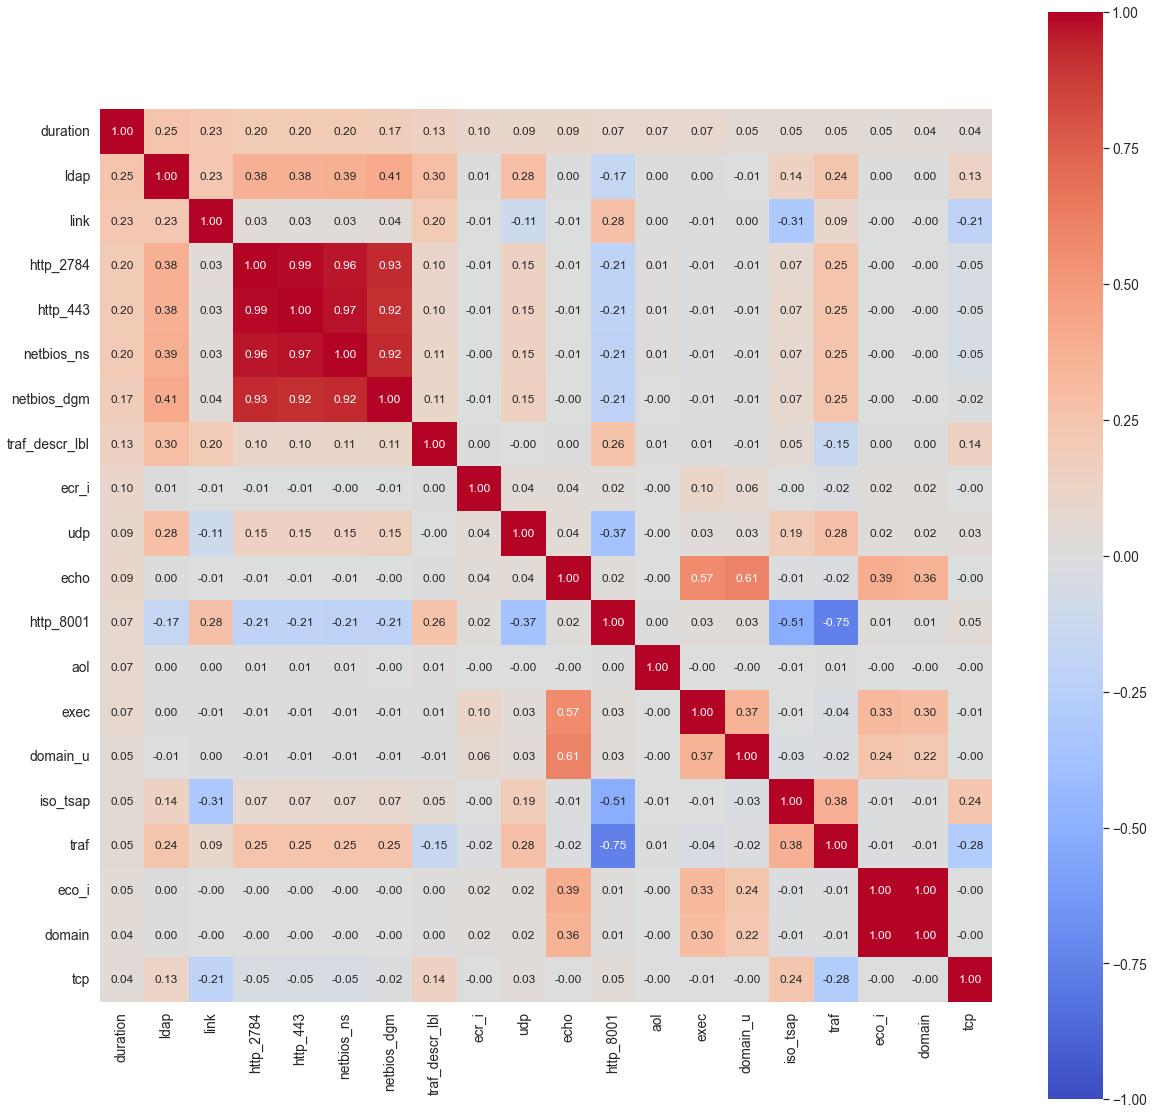

In [172]:
#проверим как кореллируют продолжительность времени атаки и тип атаки по первым 20 признакам
k = 20
corrmat = dataset.corr()
cols_duration = corrmat.nlargest(k, 'duration')['traf_descr_lbl'].index.tolist()
cm = np.corrcoef(dataset[cols_duration].values.T)
plt.figure(figsize=(20,20))
sns.set(font_scale=1.25)
sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 12},\
                yticklabels=cols_duration, xticklabels=cols_duration, vmin=-1, center=0,\
                    cmap=sns.color_palette('coolwarm',1000))
plt.show()

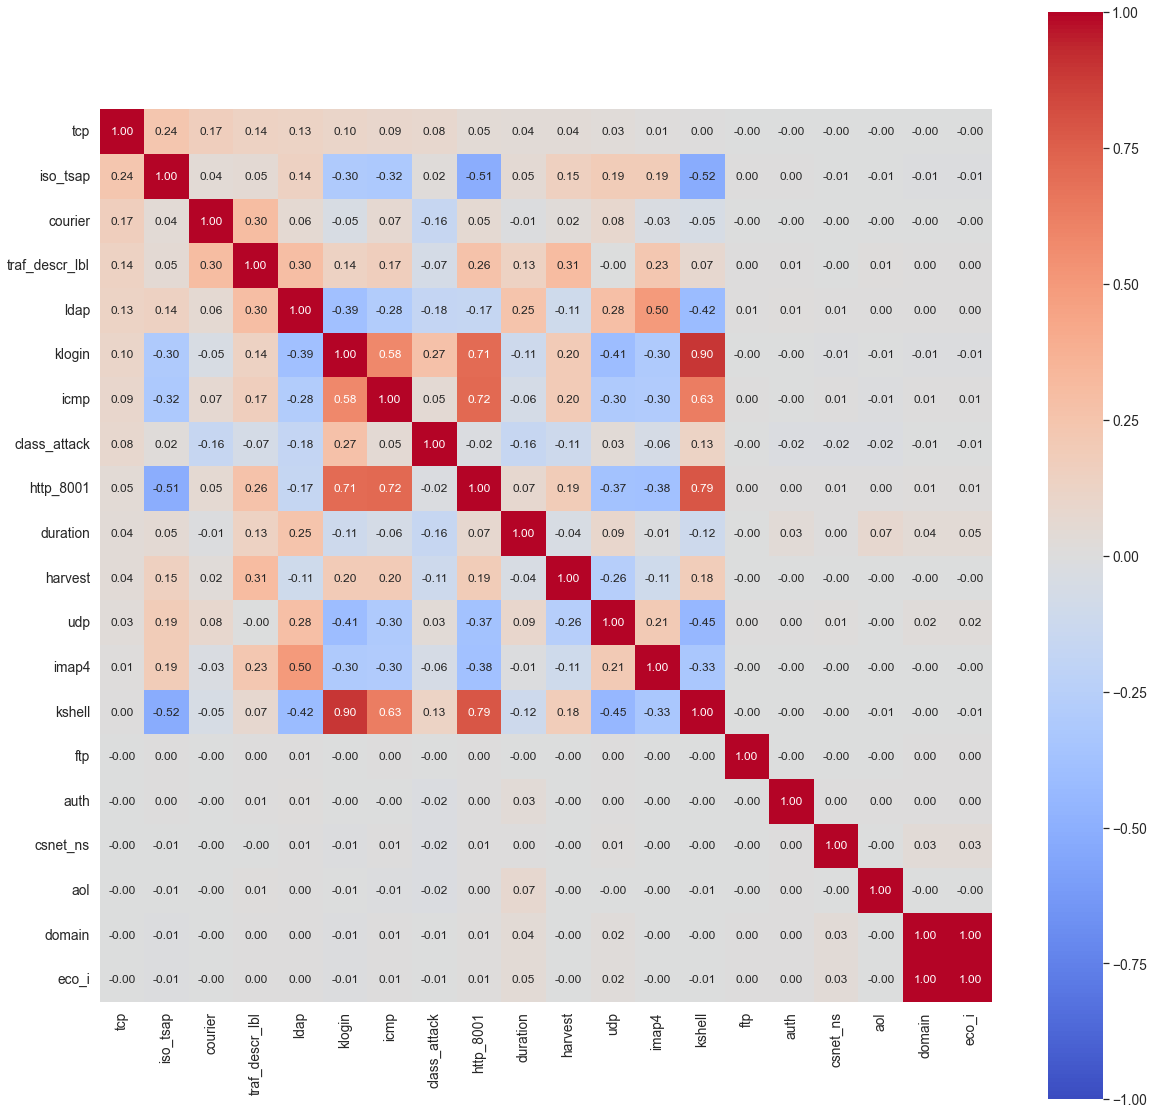

In [173]:
#проверим как кореллируют данные из таблицы tcp и тип атаки по первым 20 признакам
k = 20
corrmat = dataset.corr()
cols_ftp = corrmat.nlargest(k, 'tcp')['traf_descr_lbl'].index.tolist()
cm = np.corrcoef(dataset[cols_ftp].values.T)
plt.figure(figsize=(20,20))
sns.set(font_scale=1.25)
sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 12},\
                yticklabels=cols_ftp, xticklabels=cols_ftp, vmin=-1, center=0,\
                    cmap=sns.color_palette('coolwarm',1000))
plt.show()

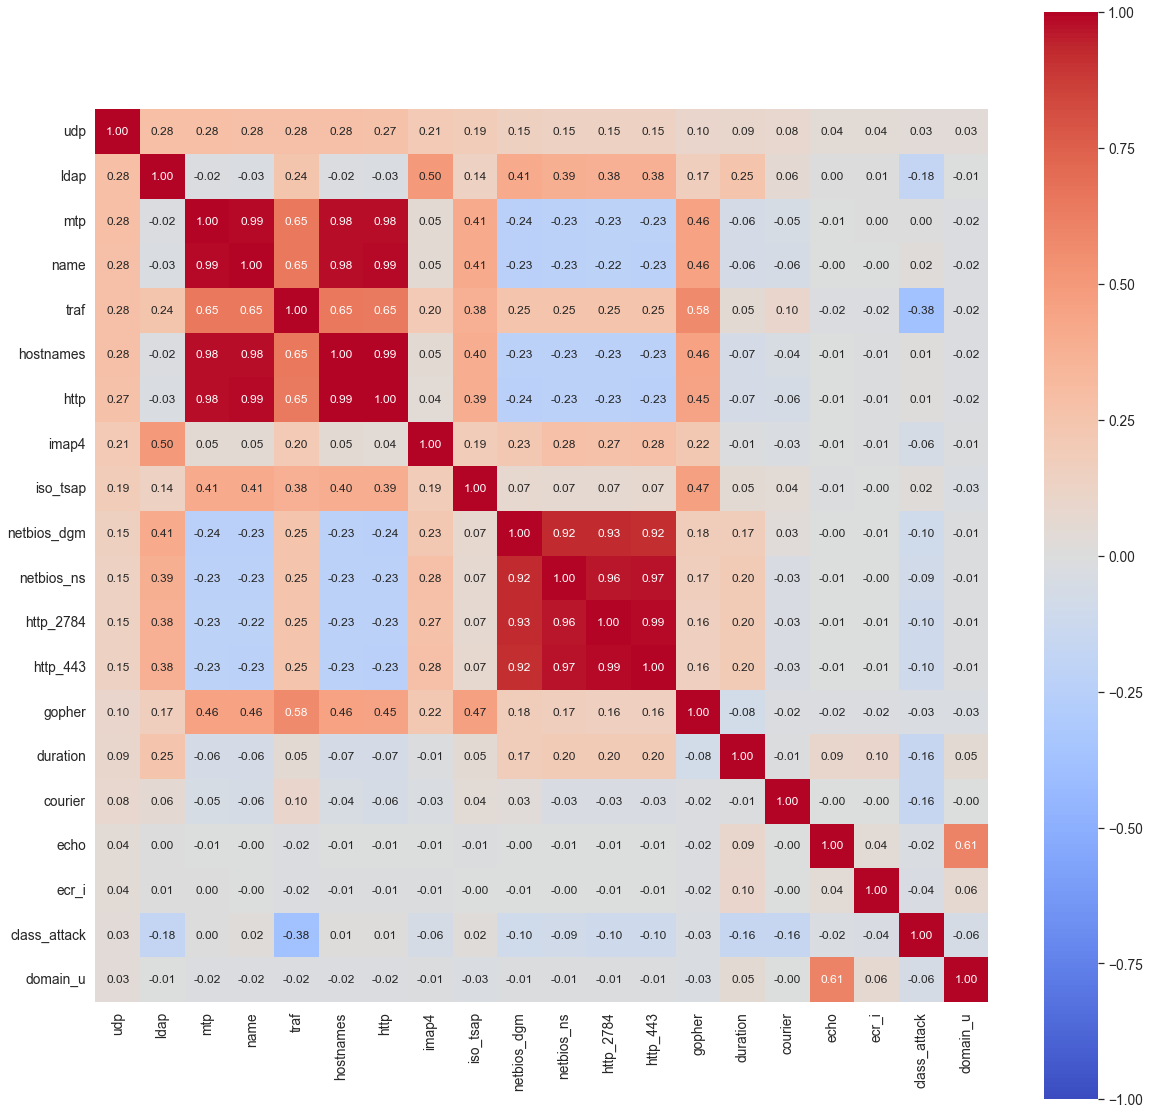

In [174]:
#проверим как кореллируют данные из таблицы udp и тип атаки по первым 20 признакам
k = 20
corrmat = dataset.corr()
cols_udp = corrmat.nlargest(k, 'udp')['traf_descr_lbl'].index.tolist()
cm = np.corrcoef(dataset[cols_udp].values.T)
plt.figure(figsize=(20,20))
sns.set(font_scale=1.25)
sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 12},\
                yticklabels=cols_udp, xticklabels=cols_udp, vmin=-1, center=0,\
                    cmap=sns.color_palette('coolwarm',1000))
plt.show()

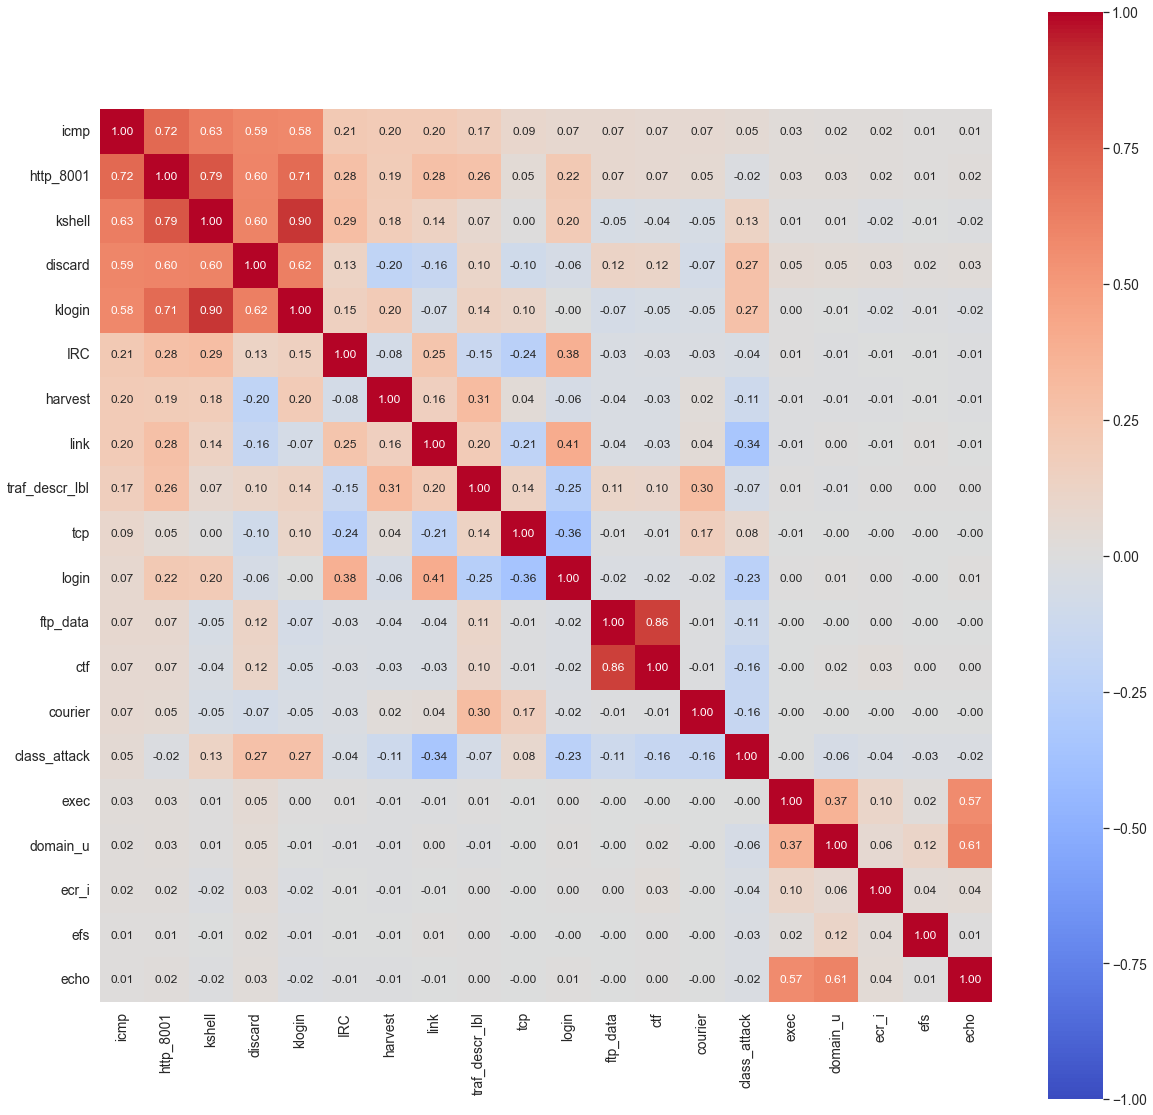

In [175]:
#проверим как кореллируют данные из таблицы icmp и тип атаки по первым 20 признакам
k = 20
corrmat = dataset.corr()
cols_icmp = corrmat.nlargest(k, 'icmp')['traf_descr_lbl'].index.tolist()
cm = np.corrcoef(dataset[cols_icmp].values.T)
plt.figure(figsize=(20,20))
sns.set(font_scale=1.25)
sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 12},\
                yticklabels=cols_icmp, xticklabels=cols_icmp, vmin=-1, center=0,\
                    cmap=sns.color_palette('coolwarm',1000))
plt.show()

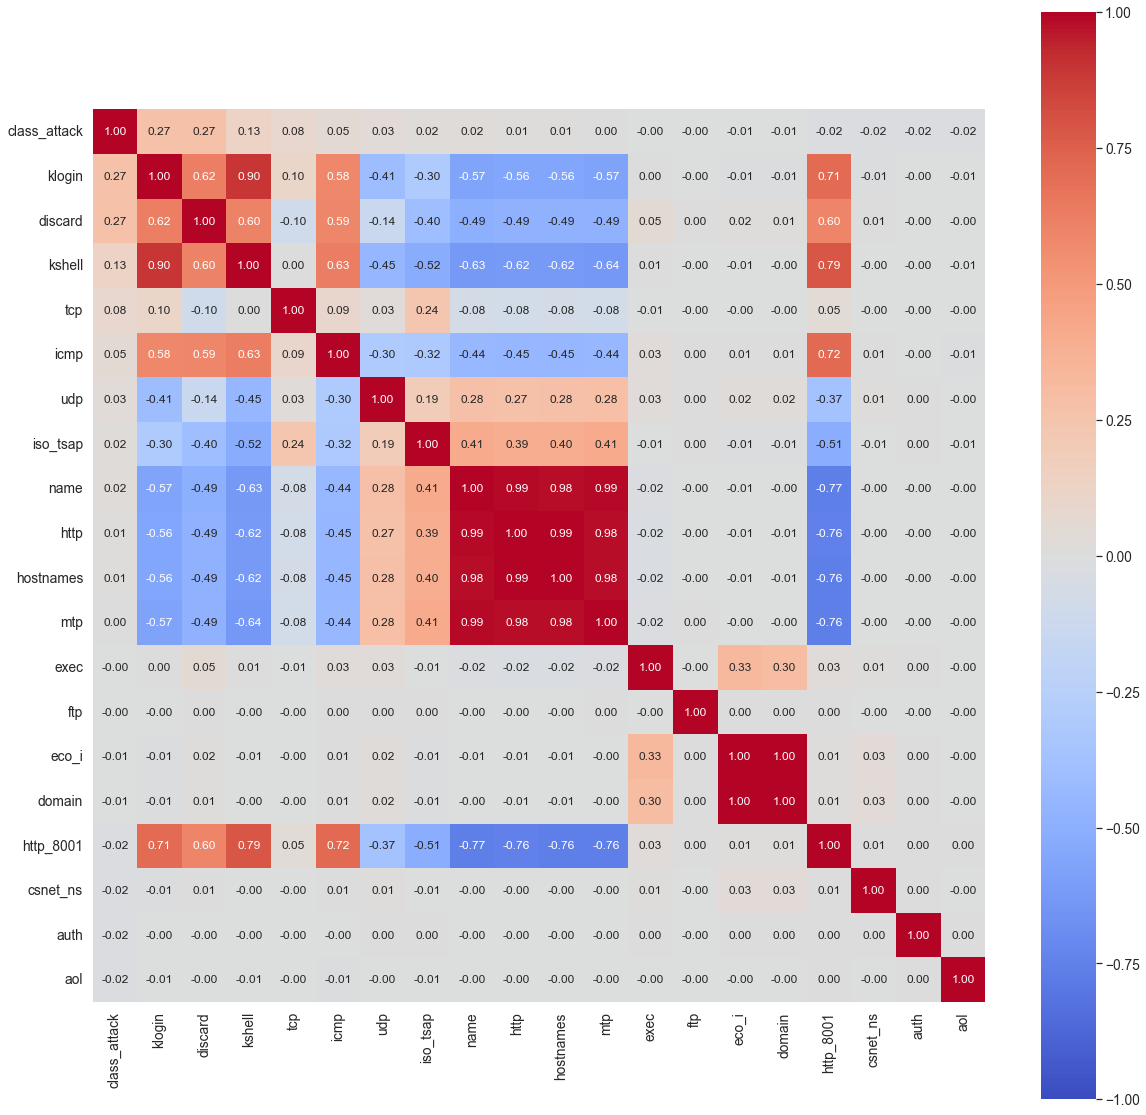

In [176]:
k = 20
corrmat = dataset.corr()
cols_icmp = corrmat.nlargest(k, 'class_attack')['traf_descr_lbl'].index.tolist()
cm = np.corrcoef(dataset[cols_icmp].values.T)
plt.figure(figsize=(20,20))
sns.set(font_scale=1.25)
sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 12},\
                yticklabels=cols_icmp, xticklabels=cols_icmp, vmin=-1, center=0,\
                    cmap=sns.color_palette('coolwarm',1000))
plt.show()

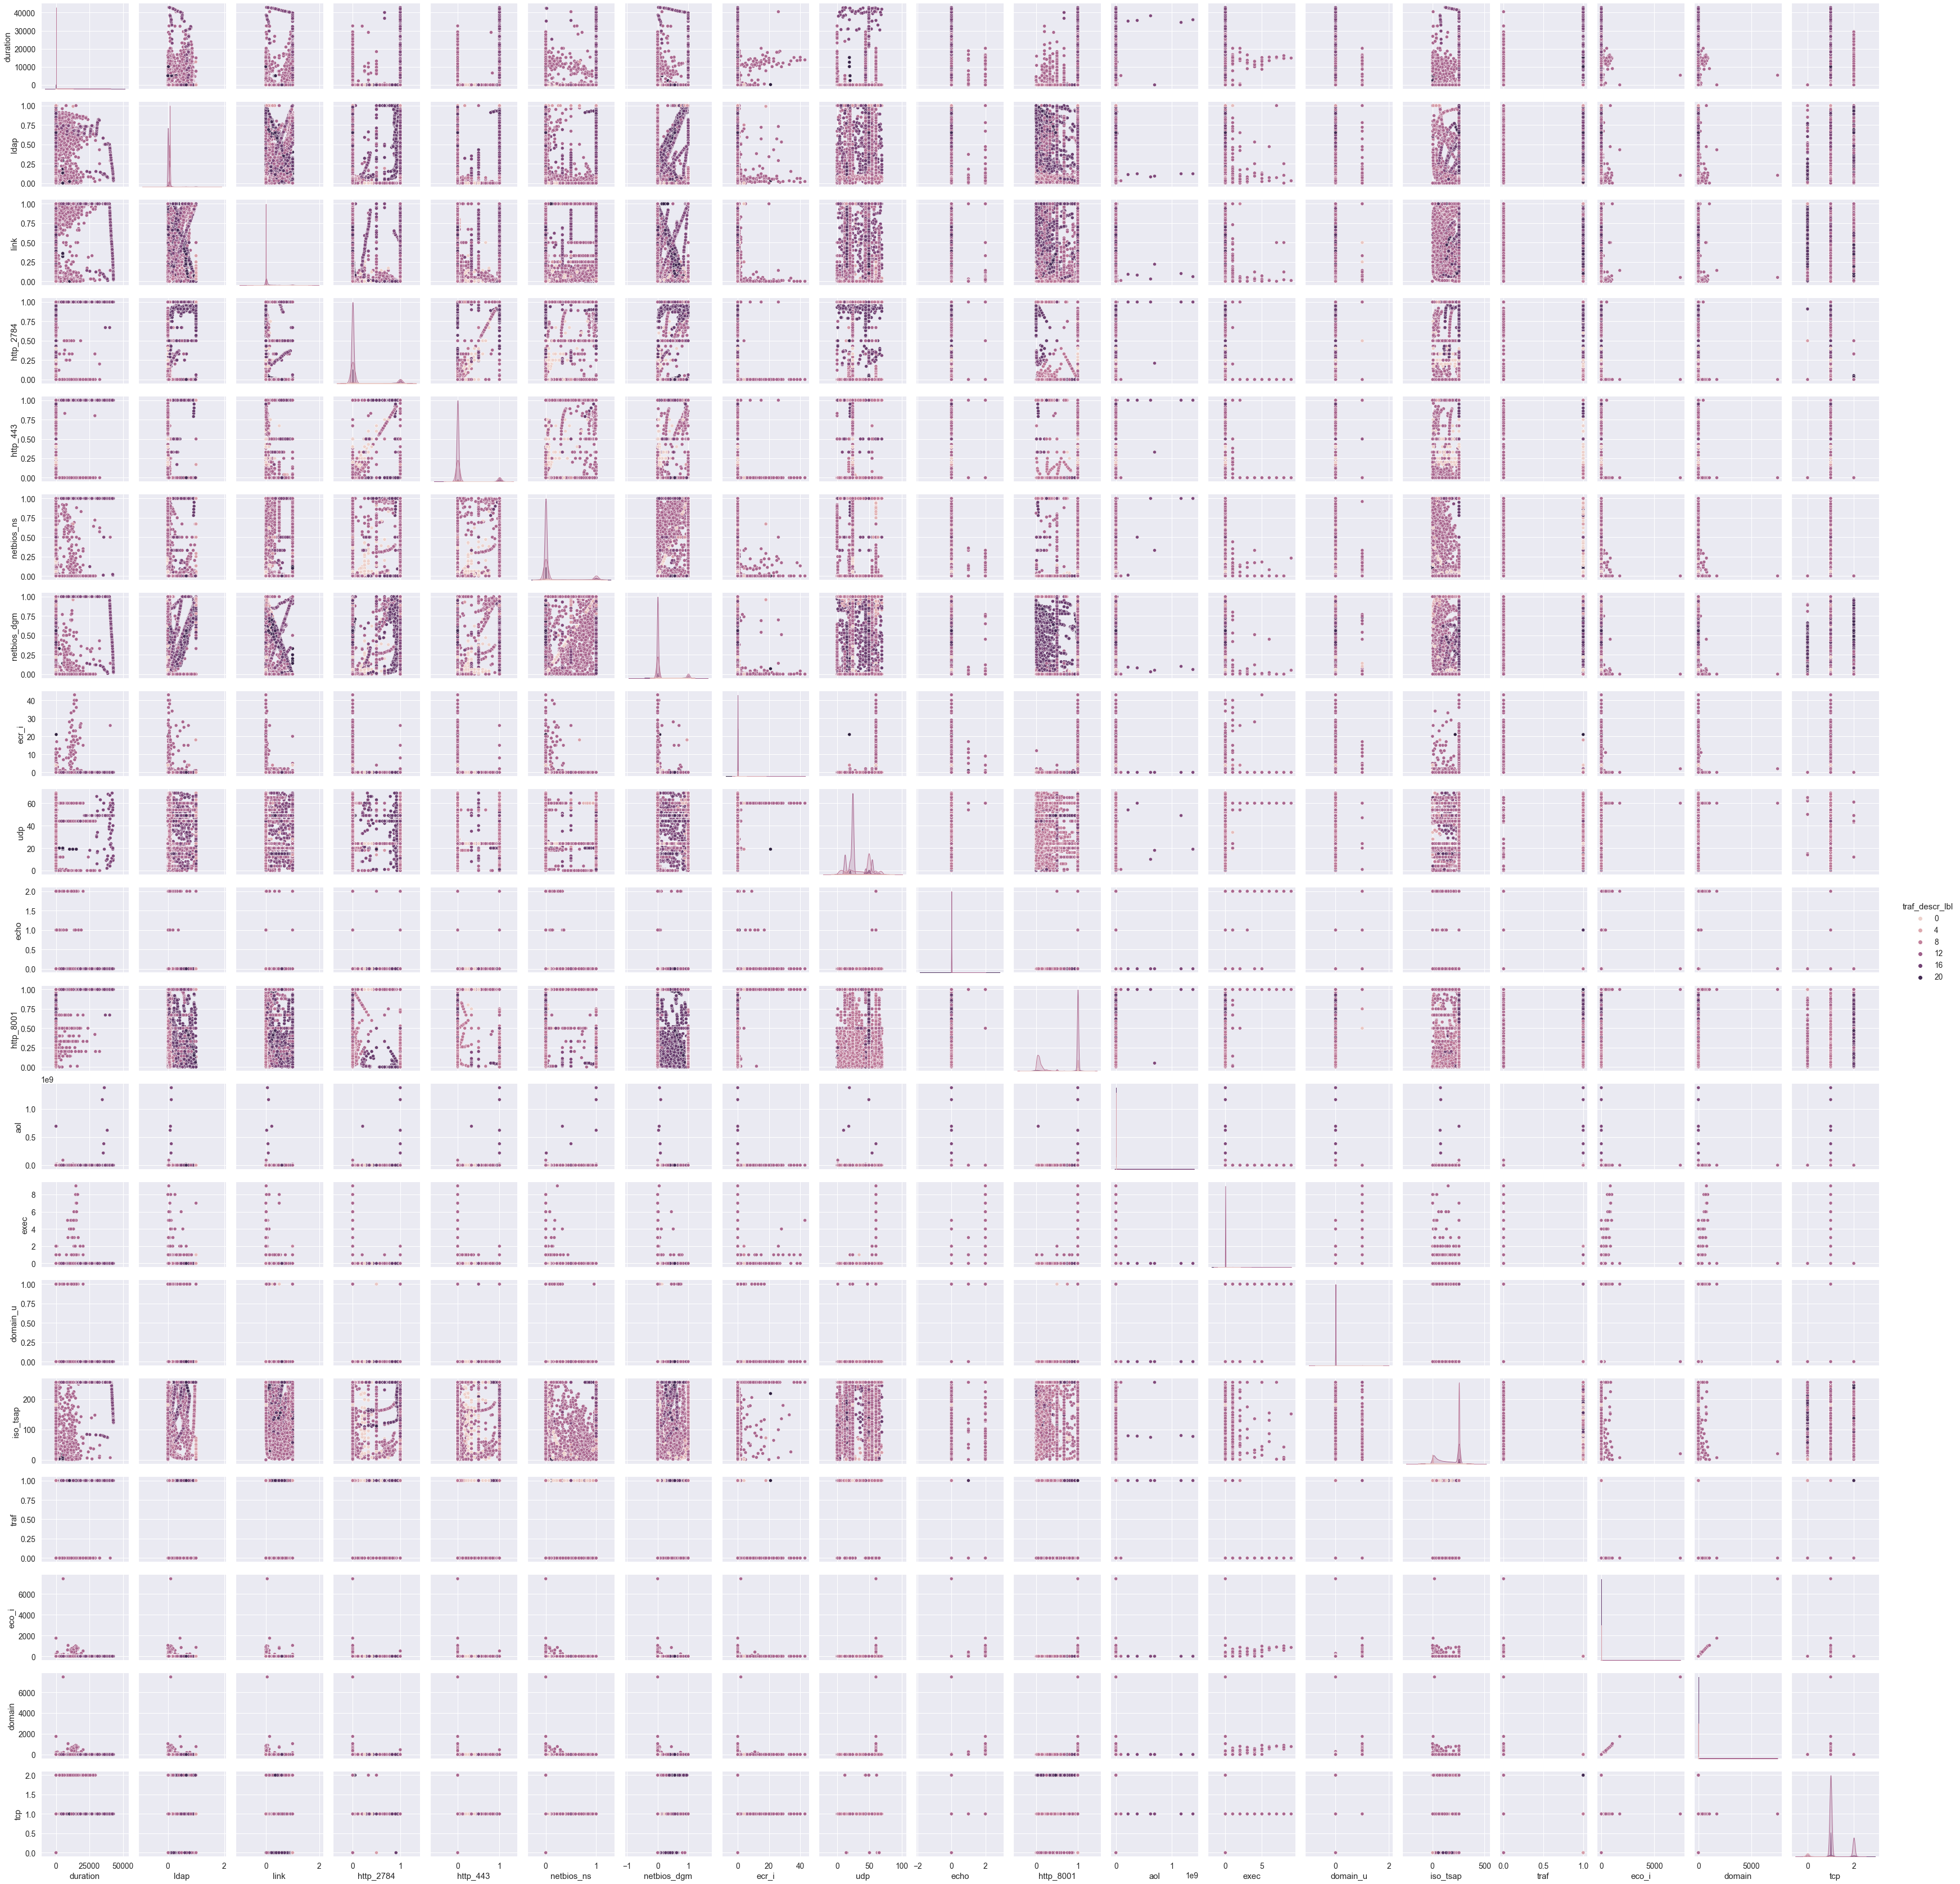

In [177]:
sns.pairplot(dataset[cols_duration], hue='traf_descr_lbl')
plt.show()

# Data split

In [45]:
#дропнем тектосвые лэйблы атак из датасета (ранее мы их все равно закодировали "traf_descr_lbl" и добавили в датасет)
dataset.drop('netbios_ssn', inplace=True, axis=1)
dataset

duration  tcp   udp  icmp   aol  auth  bgp  courier  csnet_ns  ctf  \
0              0  1.0  20.0   9.0   491     0    0        0         0    0   
1              0  2.0  44.0   9.0   146     0    0        0         0    0   
2              0  1.0  49.0   5.0     0     0    0        0         0    0   
3              0  1.0  24.0   9.0   232  8153    0        0         0    0   
4              0  1.0  24.0   9.0   199   420    0        0         0    0   
...          ...  ...   ...   ...   ...   ...  ...      ...       ...  ...   
125968         0  1.0  49.0   5.0     0     0    0        0         0    0   
125969         8  2.0  49.0   9.0   105   145    0        0         0    0   
125970         0  1.0  54.0   9.0  2231   384    0        0         0    0   
125971         0  1.0  30.0   5.0     0     0    0        0         0    0   
125972         0  1.0  20.0   9.0   151     0    0        0         0    0   

        daytime  discard  domain  domain_u  echo  eco_i  ecr_i  efs  exec  \
0             0        0       0         0     0      0      0    0     0   
1             0        0       0         0     0      0      0    0     0   
2             0        0       0         0     0      0      0    0     0   
3             0        1       0         0     0      0      0    0     0   
4             0        1       0         0     0      0      0    0     0   
...         ...      ...     ...       ...   ...    ...    ...  ...   ...   
125968        0        0       0         0     0      0      0    0     0   
125969        0        0       0         0     0      0      0    0     0   
125970        0        1       0         0     0      0      0    0     0   
125971        0        0       0         0     0      0      0    0     0   
125972        0        1       0         0     0      0      0    0     0   

        finger  ftp  ftp_data  gopher  harvest  hostnames  http  http_2784  \
0            0    0         0       2        2        0.0   0.0        0.0   
1            0    0         0      13        1        0.0   0.0        0.0   
2            0    0         0     123        6        1.0   1.0        0.0   
3            0    0         0       5        5        0.2   0.2        0.0   
4            0    0         0      30       32        0.0   0.0        0.0   
...        ...  ...       ...     ...      ...        ...   ...        ...   
125968       0    0         0     184       25        1.0   1.0        0.0   
125969       0    0         0       2        2        0.0   0.0        0.0   
125970       0    0         0       1        1        0.0   0.0        0.0   
125971       0    0         0     144        8        1.0   1.0        0.0   
125972       0    0         0       1        1        0.0   0.0        0.0   

        http_443  http_8001  imap4   IRC  iso_tsap  klogin  kshell  ldap  \
0            0.0       1.00   0.00  0.00       150      25    0.17  0.03   
1            0.0       0.08   0.15  0.00       255       1    0.00  0.60   
2            0.0       0.05   0.07  0.00       255      26    0.10  0.05   
3            0.0       1.00   0.00  0.00        30     255    1.00  0.00   
4            0.0       1.00   0.00  0.09       255     255    1.00  0.00   
...          ...        ...    ...   ...       ...     ...     ...   ...   
125968       0.0       0.14   0.06  0.00       255      25    0.10  0.06   
125969       0.0       1.00   0.00  0.00       255     244    0.96  0.01   
125970       0.0       1.00   0.00  0.00       255      30    0.12  0.06   
125971       0.0       0.06   0.05  0.00       255       8    0.03  0.05   
125972       0.0       1.00   0.00  0.00       255      77    0.30  0.03   

        link  login   mtp  name  netbios_dgm  netbios_ns  class_attack  \
0       0.17   0.00  0.00  0.00         0.05        0.00            20   
1       0.88   0.00  0.00  0.00         0.00        0.00            15   
2       0.00   0.00  1.00  1.00         0.00        0.00            19   


In [46]:
dataset.columns.to_numpy()[0:44]

array(['duration', 'tcp', 'udp', 'icmp', 'aol', 'auth', 'bgp', 'courier',
       'csnet_ns', 'ctf', 'daytime', 'discard', 'domain', 'domain_u',
       'echo', 'eco_i', 'ecr_i', 'efs', 'exec', 'finger', 'ftp',
       'ftp_data', 'gopher', 'harvest', 'hostnames', 'http', 'http_2784',
       'http_443', 'http_8001', 'imap4', 'IRC', 'iso_tsap', 'klogin',
       'kshell', 'ldap', 'link', 'login', 'mtp', 'name', 'netbios_dgm',
       'netbios_ns', 'class_attack', 'traf_descr_lbl', 'traf'],
      dtype=object)

In [47]:
dataset.columns.to_numpy()[43]

'traf'

In [48]:
#разбиение данных из датасета на трейн и тест
from sklearn.model_selection import train_test_split
X = dataset.iloc[:, 0:43].values
y = dataset.iloc[:, 43].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=555)
print("Train set:", X_train.shape, y_train.shape)
print("Test set:", X_test.shape, y_test.shape)

Train set: (88181, 43) (88181,)
Test set: (37792, 43) (37792,)


In [49]:
X[0:5]

array([[0.000e+00, 1.000e+00, 2.000e+01, 9.000e+00, 4.910e+02, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 2.000e+00, 2.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00, 0.000e+00,
        0.000e+00, 1.500e+02, 2.500e+01, 1.700e-01, 3.000e-02, 1.700e-01,
        0.000e+00, 0.000e+00, 0.000e+00, 5.000e-02, 0.000e+00, 2.000e+01,
        1.100e+01],
       [0.000e+00, 2.000e+00, 4.400e+01, 9.000e+00, 1.460e+02, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 1.300e+01, 1.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 8.000e-02, 1.500e-01,
        0.000e+00, 2.550e+02, 1.000e+00, 0.000e+00, 6.000e-01, 8.800e-01,
        0.000e+00,

In [50]:
#нормализуем данные
from sklearn import preprocessing
X= preprocessing.StandardScaler().fit(X).transform(X)
X[0:5]

array([[-0.11024922, -0.12470616, -0.68678521,  0.75111129, -0.0076786 ,
        -0.00491864, -0.01408881, -0.08948642, -0.00773599, -0.09507567,
        -0.02702282, -0.80926182, -0.01166364, -0.03665187, -0.02443651,
        -0.01238515, -0.02618002, -0.0186099 , -0.0412212 ,  0.        ,
        -0.00281749, -0.09753094, -0.71704549, -0.35434285, -0.63720927,
        -0.63192903, -0.37436224, -0.3744316 ,  0.77128311, -0.34968303,
        -0.3745597 , -0.32406309, -0.81888998, -0.78236683, -0.28028168,
         0.06997226, -0.2891034 , -0.63953191, -0.6248708 , -0.22453241,
        -0.37638703,  0.21642633,  0.14207372],
       [-0.11024922,  2.21931185,  0.78142753,  0.75111129, -0.00773737,
        -0.00491864, -0.01408881, -0.08948642, -0.00773599, -0.09507567,
        -0.02702282, -0.80926182, -0.01166364, -0.03665187, -0.02443651,
        -0.01238515, -0.02618002, -0.0186099 , -0.0412212 ,  0.        ,
        -0.00281749, -0.09753094, -0.62098246, -0.36811021, -0.63720927,
   

In [51]:
y_test

array([1., 0., 0., ..., 1., 1., 1.])

In [52]:
pd.unique(y_test)

array([1., 0.])

# Classification

In [53]:
from sklearn.model_selection import GridSearchCV
#from sklearn.metrics import classification_report, 
# confusion_matrix, 
# f1_score, make_scorer, 
# accuracy_score, 
# mean_squared_error

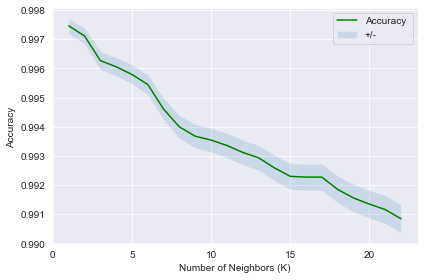

Best accuracy: 0.9974597798475868 k= 1
MSE:  0.009155376799322608


In [29]:
#K Nearest Neighbor(KNN)
#подбор лучшего значения количества соседей
from sklearn.neighbors import KNeighborsClassifier
clss = 23
mean_acc = np.zeros((clss-1))
std_acc = np.zeros((clss-1))


for k in range(1,clss):
      
    knn = KNeighborsClassifier(n_neighbors = k).fit(X_train,y_train)
    knn_pred=knn.predict(X_test)
    
    mean_acc[k-1] = metrics.accuracy_score(y_test, knn_pred)
    std_acc[k-1]=np.std(knn_pred==y_test)/np.sqrt(knn_pred.shape[0])

plt.plot(range(1,clss),mean_acc,'g')
plt.fill_between(range(1,clss),mean_acc - 1 * std_acc,mean_acc + 1 * std_acc, alpha=0.15)
plt.legend(('Accuracy ', '+/-'))
plt.ylabel('Accuracy ')
plt.xlabel('Number of Neighbors (K)')
plt.tight_layout()
plt.show()

print( "Best accuracy:", mean_acc.max(), "k=", mean_acc.argmax()+1)
print("MSE: ",metrics.mean_squared_error(y_test, knn_pred))



In [30]:
#Decision Tree (DecisionTreeClassifier)
#подбор лучших параметров для модели DecisionTreeClassifier
from sklearn.tree import DecisionTreeClassifier

# зададим модель для которой будем выполнять подбор
dt = DecisionTreeClassifier(random_state=111)

# параметры модели
parameters = {
    'max_depth':[1, 3, 5, 7, 10],
    'min_samples_split' : [2,5,10,20],
    'min_samples_leaf':[1, 5, 10,50],
    'criterion': ['gini', 'entropy', 'log_loss']
    }

# Define GridSearch parameters
dt_grid = GridSearchCV(dt,               # Classifier object to optimize
                  parameters,          # Grid of the hyperparameters
                  scoring='accuracy',  # Claasification quality metric to optimize
                  cv=3)                # Number of folds in KFolds cross-validation (CV)


# Run Grid Search optimization
dt_grid.fit(X_train, y_train)
dt_grid.best_params_

# best_params: 'criterion': 'entropy', 'max_depth': 3, 'min_samples_leaf': 1,'min_samples_split': 2


{'criterion': 'entropy',
 'max_depth': 3,
 'min_samples_leaf': 1,
 'min_samples_split': 2}

In [45]:
# save the model to disk
#pickle.dump(dt_grid, open('dt_model.sav', 'wb'))

In [187]:
dt_pred = dt_grid.predict(X_test)

print(metrics.classification_report(y_test,dt_pred))
print("MSE: ",metrics.mean_squared_error(y_test, dt_pred))
print("Train set Acc: ", metrics.accuracy_score(y_train, dt_grid.predict(X_train)))
print("Test set Acc: ", metrics.accuracy_score(y_test, dt_pred))

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     20057
         1.0       1.00      1.00      1.00     17735

    accuracy                           1.00     37792
   macro avg       1.00      1.00      1.00     37792
weighted avg       1.00      1.00      1.00     37792

MSE:  0.0
Train set Acc:  1.0
Test set Acc:  1.0


In [31]:
#Random forest
#подбор лучших параметров для модели
from sklearn.ensemble import RandomForestClassifier

# зададим модель для которой будем выполнять подбор
rf = RandomForestClassifier(random_state=112)

# параметры модели
parameters = {
    'n_estimators': [200, 500],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [4,5,6,7,8],
    'criterion' :['gini', 'entropy']
    }

# Define GridSearch parameters
rf_grid = GridSearchCV(rf,               # Classifier object to optimize
                  parameters,          # Grid of the hyperparameters
                  scoring='accuracy',  # Claasification quality metric to optimize
                  cv=3,                # Number of folds in KFolds cross-validation (CV)
                  n_jobs=4)                

# Run Grid Search optimization
rf_grid.fit(X_train, y_train)
rf_grid.best_params_

#best_params:'criterion': 'gini', 'max_depth': 8, 'max_features': 'auto', 'n_estimators': 500

{'criterion': 'gini',
 'max_depth': 8,
 'max_features': 'auto',
 'n_estimators': 500}

In [48]:
rf_pred = rf_grid.predict(X_test)

print(metrics.classification_report(y_test,rf_pred))
print("MSE: ",metrics.mean_squared_error(y_test, rf_pred))
print("Train set Acc: ", metrics.accuracy_score(y_train, rf_grid.predict(X_train)))
print("Test set Acc: ", metrics.accuracy_score(y_test, rf_pred))

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     20057
         1.0       1.00      1.00      1.00     17735

    accuracy                           1.00     37792
   macro avg       1.00      1.00      1.00     37792
weighted avg       1.00      1.00      1.00     37792

MSE:  2.6460626587637594e-05
Train set Acc:  1.0
Test set Acc:  0.9999735393734124


In [49]:
# save the model to disk
#pickle.dump(rf_grid, open('rf_model.sav', 'wb'))

In [32]:
#GBM
#подбор лучших параметров для модели GradientBoostingClassifier
from sklearn.ensemble import GradientBoostingClassifier

# зададим модель для которой будем выполнять подбор
gb = GradientBoostingClassifier(random_state=113)

# параметры модели
parameters = {
    "loss":["deviance"],
    "learning_rate": [0.01, 0.025, 0.05, 0.075, 0.1, 0.15, 0.2],
    "min_samples_split": np.linspace(0.1, 0.5, 12),
    "min_samples_leaf": np.linspace(0.1, 0.5, 12),
    "max_depth":[3,5,8],
    "max_features":["log2","sqrt"],
    "criterion": ["friedman_mse",  "mae"],
    "subsample":[0.5, 0.618, 0.8, 0.85, 0.9, 0.95, 1.0],
    "n_estimators":[10]
    }

# Define GridSearch parameters
gb_grid = GridSearchCV(gb,               # Classifier object to optimize
                  parameters,          # Grid of the hyperparameters
                  scoring='accuracy',  # Claasification quality metric to optimize
                  cv=3,                # Number of folds in KFolds cross-validation (CV)
                  n_jobs=4)

# Run Grid Search optimization
gb_grid.fit(X_train, y_train)
gb_grid.best_params_

#best_params:'criterion': 'friedman_mse', 'learning_rate': 0.2, 'loss': 'deviance', 'max_depth': 5, 'max_features': 'sqrt',
# 'min_samples_leaf': 0.1, 'min_samples_split': 0.31818181818181823, 'n_estimators': 10, 'subsample': 1.0

In [51]:
gb_pred = gb_grid.predict(X_test)

print(metrics.classification_report(y_test,gb_pred))
print("MSE: ",metrics.mean_squared_error(y_test, gb_pred))
print("Train set Acc: ", metrics.accuracy_score(y_train, gb_grid.predict(X_train)))
print("Test set Acc: ", metrics.accuracy_score(y_test, gb_pred))

              precision    recall  f1-score   support

         0.0       0.94      0.99      0.97     20057
         1.0       0.99      0.93      0.96     17735

    accuracy                           0.96     37792
   macro avg       0.96      0.96      0.96     37792
weighted avg       0.96      0.96      0.96     37792

MSE:  0.037785774767146486
Train set Acc:  0.9630872863768839
Test set Acc:  0.9622142252328535


In [52]:
# save the model to disk
#pickle.dump(gb_grid, open('gb_model.sav', 'wb'))

In [ ]:
#xgboost
#подбор лучших параметров для модели GradientBoostingClassifier
from xgboost.sklearn import XGBClassifier

xgb = XGBClassifier(random_state=121)

parameters = {
    'learning_rate':[0.01, 0.03, 0.1],
    "min_child_weight":[1, 5, 15],
    'max_depth':[2, 6, 12],
    'n_estimators':[100],
    'colsample_bytree':[0.5, 0.75, 1], 
    "subsample":[0.5, 0.75, 1]
    }
              

xgb_grid = GridSearchCV(xgb,
                        parameters,
                        cv=3,
                        scoring='accuracy',
                        n_jobs=4)

xgb_grid.fit(X_train, y_train)
xgb_grid.best_params_

#best_params:'colsample_bytree': 0.5, 'learning_rate': 0.01, 'max_depth': 2, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.5


{'colsample_bytree': 0.5,
 'learning_rate': 0.01,
 'max_depth': 2,
 'min_child_weight': 1,
 'n_estimators': 100,
 'subsample': 0.5}

In [54]:
pred_xgb = xgb_grid.predict(X_test)

print(metrics.classification_report(y_test,pred_xgb))
print("MSE: ",metrics.mean_squared_error(y_test, pred_xgb))
print("Train set Acc: ", metrics.accuracy_score(y_train, xgb_grid.predict(X_train)))
print("Test set Acc: ", metrics.accuracy_score(y_test, pred_xgb))

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     20057
         1.0       1.00      1.00      1.00     17735

    accuracy                           1.00     37792
   macro avg       1.00      1.00      1.00     37792
weighted avg       1.00      1.00      1.00     37792

MSE:  0.0
Train set Acc:  1.0
Test set Acc:  1.0


In [55]:
# save the model to disk
#pickle.dump(xgb_grid, open('xgb_model.sav', 'wb'))

In [ ]:
#Catboost
#подбор лучших параметров для модели  CatBoostClassifier
from catboost import  CatBoostClassifier

# зададим модель для которой будем выполнять подбор
ctb = CatBoostClassifier(random_state=223)

# параметры модели
parameters = {
    'iterations' : [10,50,100,150], 
    'learning_rate' :[0.01,0.1],
    'max_depth':[3,5,7,10],
    'loss_function': ['RMSE', 'Logloss', 'CrossEntropy'],
    'l2_leaf_reg': np.logspace(-20, -19, 3),
    'leaf_estimation_iterations': [10],
    }

# Define GridSearch parameters
ctb_grid = GridSearchCV(ctb,           # Classifier object to optimize
                  parameters,          # Grid of the hyperparameters
                  scoring='accuracy',  # Claasification quality metric to optimize
                  cv=3,                # Number of folds in KFolds cross-validation (CV)
                  n_jobs=4)                


# Run Grid Search optimization
ctb_grid.fit(X_train, y_train)
ctb_grid.best_params_

#best_param: 'iterations': 10, 'l2_leaf_reg': 1e-20, 'leaf_estimation_iterations': 10, 'learning_rate': 0.01, 'loss_function': 'Logloss', 'max_depth': 3

0:	learn: 0.6425652	total: 65.3ms	remaining: 588ms
1:	learn: 0.6071905	total: 80.4ms	remaining: 322ms
2:	learn: 0.5620536	total: 94.9ms	remaining: 221ms
3:	learn: 0.5164392	total: 110ms	remaining: 165ms
4:	learn: 0.4795108	total: 125ms	remaining: 125ms
5:	learn: 0.4433116	total: 138ms	remaining: 92ms
6:	learn: 0.4110865	total: 152ms	remaining: 65ms
7:	learn: 0.3795037	total: 164ms	remaining: 41.1ms
8:	learn: 0.3506863	total: 178ms	remaining: 19.8ms
9:	learn: 0.3238785	total: 192ms	remaining: 0us


{'iterations': 10,
 'l2_leaf_reg': 1e-20,
 'leaf_estimation_iterations': 10,
 'learning_rate': 0.01,
 'loss_function': 'Logloss',
 'max_depth': 3}

In [57]:
pred_ctb = ctb_grid.predict(X_test)


print(metrics.classification_report(y_test,pred_ctb))
print("MSE: ",metrics.mean_squared_error(y_test, pred_ctb))
print("Train set Acc: ", metrics.accuracy_score(y_train, ctb_grid.predict(X_train)))
print("Test set Acc: ", metrics.accuracy_score(y_test, pred_ctb))

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     20057
         1.0       1.00      1.00      1.00     17735

    accuracy                           1.00     37792
   macro avg       1.00      1.00      1.00     37792
weighted avg       1.00      1.00      1.00     37792

MSE:  5.292125317527519e-05
Train set Acc:  0.9999886596885951
Test set Acc:  0.9999470787468248


In [58]:
# save the model to disk
#pickle.dump(ctb_grid, open('ctb_model.sav', 'wb'))

In [ ]:
#LogisticRegression
#подбор лучших параметров для модели LogisticRegression
from sklearn.linear_model import LogisticRegression


# зададим модель для которой будем выполнять подбор
lr = LogisticRegression(random_state=231)

# параметры модели
parameters = {'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
              'penalty':['elasticnet', 'l1', 'l2'],
              'C':[0.001, 0.01, 0.1, 1, 10, 100]}

# Define GridSearch parameters
lr_grid = GridSearchCV(lr,             # Classifier object to optimize
                  parameters,          # Grid of the hyperparameters
                  scoring='accuracy',  # Claasification quality metric to optimize
                  cv=3,                # Number of folds in KFolds cross-validation (CV)
                  n_jobs=4)               


# Run Grid Search optimization
lr_grid.fit(X_train, y_train)
lr_grid.best_params_

#best_params: 'C': 100, 'penalty': 'l2', 'solver': 'newton-cg'

{'C': 100, 'penalty': 'l1', 'solver': 'liblinear'}

In [60]:
pred_lr = lr_grid.predict(X_test)

print(metrics.classification_report(y_test,pred_lr))
print("MSE: ",metrics.mean_squared_error(y_test, pred_lr))
print("Train set Acc: ", metrics.accuracy_score(y_train, lr_grid.predict(X_train)))
print("Test set Acc: ", metrics.accuracy_score(y_test, pred_lr))

              precision    recall  f1-score   support

         0.0       0.98      0.97      0.98     20057
         1.0       0.97      0.98      0.98     17735

    accuracy                           0.98     37792
   macro avg       0.98      0.98      0.98     37792
weighted avg       0.98      0.98      0.98     37792

MSE:  0.021935859441151565
Train set Acc:  0.9786802145586918
Test set Acc:  0.9780641405588484


In [61]:
# save the model to disk
#pickle.dump(lr_grid, open('lr_model.sav', 'wb'))

Validation

In [62]:
val_data = pd.read_csv('../OTUS-MLPRO-FinalQualifyingWork/KDDTest+-labels.csv', sep=',', header=None)
val_data.head(5)

0     1         2     3      4   5   6   7   8   9   10  11  12  13  14  \
0   0   tcp   private   REJ      0   0   0   0   0   0   0   0   0   0   0   
1   0   tcp   private   REJ      0   0   0   0   0   0   0   0   0   0   0   
2   2   tcp  ftp_data    SF  12983   0   0   0   0   0   0   0   0   0   0   
3   0  icmp     eco_i    SF     20   0   0   0   0   0   0   0   0   0   0   
4   1   tcp    telnet  RSTO      0  15   0   0   0   0   0   0   0   0   0   

   15  16  17  18  19  20  21   22  23   24    25   26   27    28    29    30  \
0   0   0   0   0   0   0   0  229  10  0.0  0.00  1.0  1.0  0.04  0.06  0.00   
1   0   0   0   0   0   0   0  136   1  0.0  0.00  1.0  1.0  0.01  0.06  0.00   
2   0   0   0   0   0   0   0    1   1  0.0  0.00  0.0  0.0  1.00  0.00  0.00   
3   0   0   0   0   0   0   0    1  65  0.0  0.00  0.0  0.0  1.00  0.00  1.00   
4   0   0   0   0   0   0   0    1   8  0.0  0.12  1.0  0.5  1.00  0.00  0.75   

    31  32    33    34    35    36   37   38    39    40       41  42  
0  255  10  0.04  0.06  0.00  0.00  0.0  0.0  1.00  1.00  neptune  21  
1  255   1  0.00  0.06  0.00  0.00  0.0  0.0  1.00  1.00  neptune  21  
2  134  86  0.61  0.04  0.61  0.02  0.0  0.0  0.00  0.00   normal  21  
3    3  57  1.00  0.00  1.00  0.28  0.0  0.0  0.00  0.00    saint  15  
4   29  86  0.31  0.17  0.03  0.02  0.0  0.0  0.83  0.71    mscan  11

In [63]:
val_data.shape

(22544, 43)

In [64]:
#normal traf = 0 , anomaly traf = 1
preproc(val_data)
ohencoder(val_data)
val_data.drop('netbios_ssn', inplace=True, axis=1)
val_data

duration  tcp   udp  icmp    aol  auth  bgp  courier  csnet_ns  ctf  \
0             0  1.0  45.0   1.0      0     0    0        0         0    0   
1             0  1.0  45.0   1.0      0     0    0        0         0    0   
2             2  1.0  19.0   9.0  12983     0    0        0         0    0   
3             0  0.0  13.0   9.0     20     0    0        0         0    0   
4             1  1.0  55.0   2.0      0    15    0        0         0    0   
...         ...  ...   ...   ...    ...   ...  ...      ...       ...  ...   
22539         0  1.0  49.0   9.0    794   333    0        0         0    0   
22540         0  1.0  22.0   9.0    317   938    0        0         0    0   
22541         0  1.0  22.0   9.0  54540  8314    0        0         0    2   
22542         0  2.0  11.0   9.0     42    42    0        0         0    0   
22543         0  1.0  52.0   1.0      0     0    0        0         0    0   

       daytime  discard  domain  domain_u  echo  eco_i  ecr_i  efs  exec  \
0            0        0       0         0     0      0      0    0     0   
1            0        0       0         0     0      0      0    0     0   
2            0        0       0         0     0      0      0    0     0   
3            0        0       0         0     0      0      0    0     0   
4            0        0       0         0     0      0      0    0     0   
...        ...      ...     ...       ...   ...    ...    ...  ...   ...   
22539        0        1       0         0     0      0      0    0     0   
22540        0        1       0         0     0      0      0    0     0   
22541        0        1       1         0     0      0      0    0     0   
22542        0        0       0         0     0      0      0    0     0   
22543        0        0       0         0     0      0      0    0     0   

       finger  ftp  ftp_data  gopher  harvest  hostnames  http  http_2784  \
0           0    0         0     229       10        0.0  0.00        1.0   
1           0    0         0     136        1        0.0  0.00        1.0   
2           0    0         0       1        1        0.0  0.00        0.0   
3           0    0         0       1       65        0.0  0.00        0.0   
4           0    0         0       1        8        0.0  0.12        1.0   
...       ...  ...       ...     ...      ...        ...   ...        ...   
22539       0    0         0       1        1        0.0  0.00        0.0   
22540       0    0         0       2       11        0.0  0.00        0.0   
22541       0    0         0       5       10        0.0  0.00        0.0   
22542       0    0         0       4        6        0.0  0.00        0.0   
22543       0    0         0       4       10        0.0  0.00        1.0   

       http_443  http_8001  imap4   IRC  iso_tsap  klogin  kshell  ldap  link  \
0           1.0       0.04   0.06  0.00       255      10    0.04  0.06  0.00   
1           1.0       0.01   0.06  0.00       255       1    0.00  0.06  0.00   
2           0.0       1.00   0.00  0.00       134      86    0.61  0.04  0.61   
3           0.0       1.00   0.00  1.00         3      57    1.00  0.00  1.00   
4           0.5       1.00   0.00  0.75        29      86    0.31  0.17  0.03   
...         ...        ...    ...   ...       ...     ...     ...   ...   ...   
22539       0.0       1.00   0.00  0.00       100     141    0.72  0.06  0.01   
22540       0.0       1.00   0.00  0.18       197     255    1.00  0.00  0.01   
22541       0.0       1.00   0.00  0.20       255     255    1.00  0.00  0.00   
22542       0.0       1.00   0.00  0.33       255     252    0.99  0.01  0.00   
22543       1.0       0.25   1.00  1.00       255      21    0.08  0.03  0.00   

       login   mtp  name  netbios_dgm  netbios_ns  class_attack  \
0       0.00  0.00   0.0         1.00        1.00            21   
1       0.00  0.00   0.0         1.00        1.00            21   
2       0.02  0.00   0.0         0.00        0.00         

In [65]:
X_val = val_data.iloc[:, 0:43].values
y_val = val_data.iloc[:, 43].values

In [66]:
X_val = preprocessing.StandardScaler().fit(X_val).transform(X_val)
X_val[0:5]

array([[-1.55534087e-01, -1.76303350e-01,  9.33963564e-01,
        -1.82995412e+00, -2.19881116e-02, -9.68959693e-02,
        -1.76238573e-02, -5.91039397e-02, -1.94592491e-02,
        -1.13521167e-01, -1.43998946e-01, -8.90372630e-01,
        -1.64935580e-02, -4.94534133e-02, -1.26377698e-02,
        -1.42592275e-02, -1.29109379e-02, -2.40204668e-02,
        -5.23180306e-02,  0.00000000e+00, -2.20946351e-02,
        -1.71071323e-01,  1.16676411e+00, -2.37191186e-01,
        -3.48467998e-01, -3.47389984e-01,  1.83014081e+00,
         1.83760390e+00, -1.69785930e+00, -1.31492165e-01,
        -3.86962558e-01,  6.50093198e-01, -1.16969750e+00,
        -1.30536996e+00, -1.38369640e-01, -4.31856186e-01,
        -2.29980411e-01, -3.58117560e-01, -3.52749598e-01,
         1.97979091e+00,  1.92911620e+00,  6.98325370e-01,
        -2.43297224e-01],
       [-1.55534087e-01, -1.76303350e-01,  9.33963564e-01,
        -1.82995412e+00, -2.19881116e-02, -9.68959693e-02,
        -1.76238573e-02, -5.91

In [67]:
y_val

array([1., 1., 0., ..., 1., 0., 1.])

In [68]:
pd.unique(y_val)

array([1., 0.])

In [70]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost.sklearn import XGBClassifier
from catboost import  CatBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_validate

In [76]:
models = {
    "KNN": KNeighborsClassifier(),
    "DecisionTree": DecisionTreeClassifier(),
    "RandomForest": RandomForestClassifier(),
    "GBM": GradientBoostingClassifier(),
    "XGB": XGBClassifier(),
    "Catboost": CatBoostClassifier(),
    "LR": LogisticRegression()
}

resultModelScore = pd.DataFrame(columns=['model', 'train_score', 'test_score'])

for key in models.keys():
    cross_vall = cross_validate(models[key], X_val, y_val, return_train_score=True, scoring="f1", cv=5, n_jobs=-1)

    result = {
        'model': key,
        'train_score': cross_vall["train_score"].mean(),
        'test_score': cross_vall["test_score"].mean(),
        'fit_time': cross_vall["fit_time"].mean(),
        'score_time': cross_vall["score_time"].mean()
    }

    resultModelScore = resultModelScore.append(result, ignore_index=True)
    print('cross_vall for model ', key, "done.")

resultModelScore

cross_vall for model  KNN done.
cross_vall for model  DecisionTree done.
cross_vall for model  RandomForest done.
cross_vall for model  GBM done.
cross_vall for model  XGB done.
cross_vall for model  Catboost done.
cross_vall for model  LR done.


model train_score test_score  fit_time  score_time
0           KNN    0.997935    0.99704    0.0146      1.0208
1  DecisionTree         1.0        1.0    0.0390      0.0036
2  RandomForest         1.0   0.999844    1.2390      0.0834
3           GBM         1.0        1.0    4.0990      0.0088
4           XGB         1.0        1.0    1.5130      0.0138
5      Catboost         1.0   0.999961   16.7376      0.0774
6            LR    0.969368   0.968647    0.4430      0.0042

In [81]:
# load the model LogisticRegression from disk
lr_best = pickle.load(open('lr_model.sav', 'rb'))
result_lr = lr_best.score(X_val, y_val)

print(metrics.classification_report(y_val, lr_best.predict(X_val)))
print("MSE: ",metrics.mean_squared_error(y_val, lr_best.predict(X_val)))
print('model_score = ', result_lr)

              precision    recall  f1-score   support

         0.0       0.73      0.83      0.77      9711
         1.0       0.85      0.76      0.81     12833

    accuracy                           0.79     22544
   macro avg       0.79      0.80      0.79     22544
weighted avg       0.80      0.79      0.79     22544

MSE:  0.20901348474095102
model_score =  0.790986515259049


TODO

In [229]:

#TODO clustering DBscan
#TODO LightGBM
#TODO отрисовать граф дерева
#TODO stacking, blending
#TODO Pipeline + model + validation data